In [1]:
#import packages
import pandas as pd
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request, json
import requests
import urllib.parse
import datetime
import nltk
nltk.download([
        "names",
        "stopwords",
        "averaged_perceptron_tagger",
        "vader_lexicon",
        "punkt",])

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package names to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### NYC Open Data:
    
SODA API Urls:

* 311 Call Inquiries: `https://data.cityofnewyork.us/resource/wewp-mm3p.json`

 **Important Column Names:**

   * uniqueid = 'UNIQUE_ID'
   * cat_clnm = 'AGENCY_NAME'
   * subcat_clnm = 'INQUIRY_NAME'
   * subsubcat_clnm = 'BRIEF_DESCRIPTION'
   * datetime_clnm = 'DATE_TIME'


* 311 Web Inquiries: `https://data.cityofnewyork.us/resource/vwpc-kje2.json`

 **Important Column Names:**

   * uniqueid = 'simple_id'
   * cat_clnm = 'service_name'
   * subcat_clnm = 'brief_description'
   * subsubcat_clnm = 'detailed_description'
   * datetime_clnm = 'updated_date'

In [2]:
calls =  'https://data.cityofnewyork.us/resource/wewp-mm3p.json'
web = 'https://data.cityofnewyork.us/resource/vwpc-kje2.json'

uniqueid = 'UNIQUE_ID'
cat_clnm = 'AGENCY_NAME'
subcat_clnm = 'INQUIRY_NAME'
subsubcat_clnm = 'BRIEF_DESCRIPTION'
datetime_clnm = 'DATE_TIME'
startdatetime = '2019-01-01T00:00:00.000'
enddatetime =  '2020-01-01T00:00:00.000'

query = (calls +'?'
    "$select=count(*) as count,%s as cat, %s as subcat, %s as subsubcat"
    "&$where=%s between '"+startdatetime+"' and '"+enddatetime+"'"
    "&$group=cat,subcat,subsubcat"
    "&$order=count DESC"
    "&$limit=500000"
    )%(cat_clnm,subcat_clnm,subsubcat_clnm,datetime_clnm)
query = query.replace(" ", "%20")
print(query)
response = urllib.request.urlopen(query)
data = json.loads(response.read())

https://data.cityofnewyork.us/resource/wewp-mm3p.json?$select=count(*)%20as%20count,AGENCY_NAME%20as%20cat,%20INQUIRY_NAME%20as%20subcat,%20BRIEF_DESCRIPTION%20as%20subsubcat&$where=DATE_TIME%20between%20'2019-01-01T00:00:00.000'%20and%20'2020-01-01T00:00:00.000'&$group=cat,subcat,subsubcat&$order=count%20DESC&$limit=500000


HTTPError: HTTP Error 408: Request Timeout

In [ ]:
call_comps = pd.DataFrame(data, columns = data[0].keys())
call_comps.head(10)

In [ ]:
len(call_comps)

In [ ]:
len(call_comps[call_comps['cat'].isna()])

In [ ]:
call_comps['combined_cats'] = call_comps['cat'].fillna('') \
                      .str.cat(call_comps['subcat'].fillna(''), sep=' ') \
                      .str.cat(call_comps['subsubcat'].fillna(''), sep=' ')

call_comps.head()

In [ ]:
#clean combined_cats column to prepare for NLTK processing
#lowercase
call_comps['combined_cats_lower'] = call_comps['combined_cats'].str.lower()
#make list
txt_ls = call_comps['combined_cats_lower'].tolist()

In [ ]:
import re, string

tmp_list_unique = []

for item in txt_ls:
    
    item = item.replace('sanitation', 'sanitation waste')
    item = item.replace('parks', 'parks recreation')
    item = item.replace('recreation', 'parks recreation')
    item = item.replace('watr', 'water')
    item = item.replace('wats', 'water')
    item = item.replace('wrs', 'waste')
    
    item = item.replace('park maintenance', 'recreation and parks maintenance')
    item = item.replace('park rules', 'recreation and parks rules')
    item = item.replace('park equipment', 'recreation and parks equipment')
    item = item.replace('park lawn', 'recreation and parks lawn')
    item = item.replace('park programs', 'recreation and parks program')
    item = item.replace('park light', 'recreation and parks light')
    item = item.replace('park rangers', 'recreation and parks rangers')
    item = item.replace('park surface', 'recreation and parks surface')
    item = item.replace('rec and park', 'recreation and parks')
    
    item = item.replace('wildlife', 'wildlife animal')
    item = item.replace('pigeon', 'pigeon animal')
    item = item.replace('bats', 'bats animal')
    item = item.replace('dog', 'dog animal')
    item = item.replace('stray', 'stray animal')
    item = item.replace('coyote', 'coyote animal')
    item = item.replace('pot hole', 'pothole street')
    item = item.replace('sinkhole', 'sinkhole pothole street')
    
    item = item.replace('parking', 'parking vehicles')
    item = item.replace('bugs', 'public health bugs pest control')
    itme = item.replace('mosquitoes', 'public health mosquito pest control')
    itme = item.replace('mosquito', 'public health mosquito pest control')
    itme = item.replace('roaches', 'public health roaches pest control')
    item = item.replace('mice', 'public health rats rodent pest control')
    item = item.replace('rodent', 'public health rodent rats pest control')
    item = item.replace('dumping', 'dumping waste')
    item = item.replace('illdump', 'illegal dumping waste')
    item = item.replace('plmb', 'plumbming')
    item = item.replace('haz', 'hazard')
    item = item.replace('cons', 'construction')
    item = item.replace('prmt', 'permit')
    item = item.replace('cnflct', 'conflict')
    item = item.replace('insp', 'inspection')
    item = item.replace('litter', 'litter waste')
    item = item.replace('isd', '')
    item = item.replace('traum counseling', 'trauma counseling')
    item = item.replace('dirty', 'dirty unsanitary')
    item = item.replace('bldgmaint', 'building maintenance')
    item = item.replace('derelict', 'abandonded')
    item = item.replace('blighted', 'abandonded')
    item = item.replace('vacant', 'abandonded')
    item = item.replace('building code', 'inspection code enforcement violation')
    item = item.replace('inspection', 'inspection code enforcement violation')
    item = item.replace('code enforcement', 'inspection code enforcement violation')
    item = item.replace('code violations', 'inspection code enforcement violation')
    item = item.replace('housing violations', 'inspection code enforcement violation')
    item = item.replace('property violations', 'inspection code enforcement violation')
    item = item.replace('codes compliance', 'inspection code enforcement violation')
    item = item.replace('transit', 'transit transportation')
    item = item.replace('transportation', 'transit transportation')
    item = item.replace('tenant', 'tenant housing rental')
    item = item.replace('rental issues', 'tenant housing rental')
    item = item.replace('brush', 'brush debris bulky')
    item = item.replace('loose leaf', 'brush debris bulky')
    item = item.replace('debris', 'brush debris bulky')
    item = item.replace('stlight(s)', 'street light')
    item = item.replace('collectn', 'bulky waste collection')
    item = item.replace('household appliances', 'bulky waste collection')
    item = item.replace('special collections', 'bulky waste collection')
    item = item.replace('property maintenance', 'property maintenance building residential')
    item = item.replace('building residential', 'property maintenance building residential')
    item = item.replace('forestry', 'tree')
    item = item.replace('national grid', 'electricity gas')
    item = item.replace('bicycle', 'bike')
    item = item.replace('botanical', 'tree')
    item = item.replace('property', 'property building')
    item = item.replace('pay station', 'pay station parking meter')
    item = item.replace('general inquiry', 'general information')
    item = item.replace('question', 'general information')
    item = item.replace('general questions', 'general information')
    item = item.replace('general request', 'general information')
    item = item.replace('literature request', 'general information')
    item = item.replace('program information', 'general information')
    item = item.replace('information request', 'general information')
    item = item.replace('records request', 'general information')
    
    item = item.replace('manhole', 'manhole drain')
    item = item.replace('missed collection', 'missed collection waste')
    item = item.replace('roadway', 'roads')
    
    item = item.replace('tax - ', 'tax taxpayer treasury')
    item = item.replace('compliment', 'commendation')
    
    item = item.replace('constructiontruction', 'construction')
    item = item.replace('contructionumber', 'construction')
    
    for number in ['1','2','3','4','5','6','7','8','9','0']:    
        item = item.replace(number,'')
    
    #remove symbols exc NEW CODE INSERTED BY LIZ JOHNSON 11/15/22
    symbols = "!\"\'#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in symbols:
        item = np.char.replace(item, i, '')
    
    tmp_list_unique.append(str(item).strip())

In [ ]:
print(tmp_list_unique[0:10])

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
#remove stopwords
tmp_list_unique = [[word for word in sentence.split() if word.lower() not in stopwords] for sentence in tmp_list_unique]
#join split sentences back
tmp_list_unique = [" ".join(split_sentence) for split_sentence in tmp_list_unique]

In [ ]:
print(tmp_list_unique[0:10])

In [ ]:
call_comps['processed_comps'] = tmp_list_unique

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment scores for each row in the dataframe
def get_sentiment_scores(row):
    # Use the VADER sentiment analyzer to get a sentiment score for the combined categories text
    sentiment_scores = analyzer.polarity_scores(row['processed_comps'])
    # Return the sentiment score dictionary
    return sentiment_scores

# Apply the function to each row in the dataframe and store the results in a new column
call_comps['sentiment_scores'] = call_comps.apply(get_sentiment_scores, axis=1)


In [ ]:
call_comps.head()

In [ ]:
call_comps[['neg','neu', 'pos', 'compound']] = call_comps['sentiment_scores'].apply(pd.Series)
call_comps.head()

In [ ]:
# Calculate the mean compound sentiment score for each category
mean_sentiment_scores = call_comps.groupby('combined_cats')['sentiment_scores'].apply(lambda x: x.apply(lambda y: y['compound']).mean())

In [ ]:
#save outputs
call_comps.to_csv('../Outputs/311calls_complaints_vadar_results.csv')

### Let's try and visualize the 311 inquiries' sentiment analysis results...

# RESTART FROM HERE

In [4]:
call_comps = pd.read_csv('../Outputs/311calls_complaints_vadar_results.csv', index_col = 0)
call_comps.head()

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound
0,84545,Department of Finance,Parking Ticket Lookup - Ticket or Plate Number...,Status of a parking ticket. Must know ticket o...,Department of Finance Parking Ticket Lookup - ...,department of finance parking ticket lookup - ...,department finance parking vehicles ticket loo...,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.000,0.874,0.126,0.1531
1,76516,3-1-1 Call Center,Service Request Status - General,Status of most Service Requests filed with 311.,3-1-1 Call Center Service Request Status - Gen...,3-1-1 call center service request status - gen...,call center service request status general sta...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
2,60523,Department of Finance,Property Tax Account Assistance and Bill Infor...,Help with questions about the property tax bil...,Department of Finance Property Tax Account Ass...,department of finance property tax account ass...,department finance property building tax accou...,"{'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'comp...",0.000,0.876,0.124,0.4019
3,57674,NaN,Bulk Item Disposal,"Learn how to get rid of bulk items. Schedule, ...",Bulk Item Disposal Learn how to get rid of bu...,bulk item disposal learn how to get rid of bu...,bulk item disposal learn get rid bulk items sc...,"{'neg': 0.111, 'neu': 0.889, 'pos': 0.0, 'comp...",0.111,0.889,0.000,-0.2500
4,57213,NaN,Heat or Hot Water Complaint in a Residential B...,Report a problem with heat or hot water in a r...,Heat or Hot Water Complaint in a Residential ...,heat or hot water complaint in a residential ...,heat hot water complaint residential building ...,"{'neg': 0.308, 'neu': 0.692, 'pos': 0.0, 'comp...",0.308,0.692,0.000,-0.5994


In [5]:
mean_values = call_comps[['cat','neg','neu','pos', 'compound']].groupby('cat').agg({'neg': 'mean', 'neu': 'mean', 'pos': 'mean', 'compound': 'mean'})
median_values = call_comps[['cat','neg','neu','pos', 'compound']].groupby('cat').agg({'neg': 'median', 'neu': 'median', 'pos': 'median', 'compound': 'median'})

In [6]:
mean_values.sort_values(by = 'compound', ascending = False).head(10)

,neg,neu,pos,compound
cat,,,,
New York State Justice Center For the Protection of People with Special Needs,0.000000,0.750500,0.249500,0.726900
Mayor's Office of Special Projects and Community Events,0.000000,0.798750,0.201250,0.579650
Center for Economic Opportunity,0.000000,0.709000,0.291000,0.546000
Administrative Justice Coordinator,0.000000,0.726000,0.274000,0.526700
Consumer Product Safety Commission,0.144000,0.564000,0.292000,0.440400
Ozone NY,0.000000,0.703000,0.297000,0.421500
U.S. Department of Agriculture,0.000000,0.816000,0.184000,0.363300
Mayor's Fund to Advance New York City,0.026250,0.834500,0.139250,0.351725
Small Business Services,0.022163,0.817717,0.160120,0.351542


In [7]:
median_values.sort_values(by = 'compound', ascending = False).head(10)

,neg,neu,pos,compound
cat,,,,
New York State Justice Center For the Protection of People with Special Needs,0.000,0.7505,0.2495,0.72690
Mayor's Office of Special Projects and Community Events,0.000,0.8045,0.1955,0.56015
Center for Economic Opportunity,0.000,0.7090,0.2910,0.54600
Administrative Justice Coordinator,0.000,0.7260,0.2740,0.52670
Administration for Children Services,0.000,0.7500,0.1760,0.45880
Consumer Product Safety Commission,0.144,0.5640,0.2920,0.44040
Ozone NY,0.000,0.7030,0.2970,0.42150
Small Business Services,0.000,0.8185,0.1505,0.41170
Mayor's Office of Contracts,0.000,0.8430,0.1570,0.39185


In [8]:
mean_values.sort_values(by = 'compound').head(10)

,neg,neu,pos,compound
cat,,,,
Mayor's Office to Combat Domestic Violence,0.510000,0.412500,0.077500,-0.911050
NYS Office of Alcoholism and Substance Abuse Services,0.426667,0.573333,0.000000,-0.834767
Crime Victims Board,0.537000,0.463000,0.000000,-0.792133
U.S. Department of Veterans Affairs,0.453000,0.421000,0.126000,-0.790600
NYS Emergency Management Office,0.405000,0.392000,0.203000,-0.735100
Grievance Committee for the Second and Eleventh Judicial Districts,0.276500,0.723500,0.000000,-0.617300
Civilian Complaint Review Board,0.323800,0.665800,0.010600,-0.580260
Department of Sanitation,0.280440,0.700286,0.019275,-0.532314
Jeweler's Vigilance Committee,0.468000,0.532000,0.000000,-0.526700


In [9]:
median_values.sort_values(by = 'compound').head(10)

,neg,neu,pos,compound
cat,,,,
Mayor's Office to Combat Domestic Violence,0.5315,0.3630,0.076,-0.9451
NYS Office of Alcoholism and Substance Abuse Services,0.5020,0.4980,0.000,-0.9337
U.S. Department of Veterans Affairs,0.4530,0.4210,0.126,-0.7906
NYS Board of Parole,0.3140,0.6860,0.000,-0.7506
NYS Emergency Management Office,0.4050,0.3920,0.203,-0.7351
Crime Victims Board,0.4530,0.5470,0.000,-0.7003
Civilian Complaint Review Board,0.3810,0.5960,0.000,-0.6249
Grievance Committee for the Second and Eleventh Judicial Districts,0.2765,0.7235,0.000,-0.6173
American Society for the Prevention of Cruelty to Animals,0.2620,0.7190,0.000,-0.5994


In [10]:
top_5_pos = list(mean_values.sort_values(by='compound', ascending=False)['compound'].head(5).index)
top_5_neg = list(mean_values.sort_values(by='compound', ascending=False)['compound'].tail(5).index)
print(top_5_pos,top_5_neg)

['New York State Justice Center For the Protection of People with Special Needs', "Mayor's Office of Special Projects and Community Events", 'Center for Economic Opportunity', 'Administrative Justice Coordinator', 'Consumer Product Safety Commission'] ['NYS Emergency Management Office', 'U.S. Department of Veterans Affairs', 'Crime Victims Board', 'NYS Office of Alcoholism and Substance Abuse Services', "Mayor's Office to Combat Domestic Violence"]


In [11]:
len(call_comps[call_comps['cat'] == top_5_neg[-1]])

10

In [12]:
call_comps[call_comps['cat'] == top_5_neg[-1]].sort_values(by = 'compound')

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound
2229,172,Mayor's Office to Combat Domestic Violence,Family Justice Center - Brooklyn,One-stop center for victims of domestic violen...,Mayor's Office to Combat Domestic Violence Fam...,mayor's office to combat domestic violence fam...,mayors office combat domestic violence family ...,"{'neg': 0.566, 'neu': 0.358, 'pos': 0.076, 'co...",0.566,0.358,0.076,-0.9716
2462,133,Mayor's Office to Combat Domestic Violence,Family Justice Center - Bronx,One-stop center for victims of domestic violen...,Mayor's Office to Combat Domestic Violence Fam...,mayor's office to combat domestic violence fam...,mayors office combat domestic violence family ...,"{'neg': 0.566, 'neu': 0.358, 'pos': 0.076, 'co...",0.566,0.358,0.076,-0.9716
2504,127,Mayor's Office to Combat Domestic Violence,Family Justice Center - Queens,One-stop center for victims of domestic violen...,Mayor's Office to Combat Domestic Violence Fam...,mayor's office to combat domestic violence fam...,mayors office combat domestic violence family ...,"{'neg': 0.566, 'neu': 0.358, 'pos': 0.076, 'co...",0.566,0.358,0.076,-0.9716
3059,77,Mayor's Office to Combat Domestic Violence,Family Justice Center - Manhattan,One-stop center for victims of domestic violen...,Mayor's Office to Combat Domestic Violence Fam...,mayor's office to combat domestic violence fam...,mayors office combat domestic violence family ...,"{'neg': 0.566, 'neu': 0.358, 'pos': 0.076, 'co...",0.566,0.358,0.076,-0.9716
4959,12,Mayor's Office to Combat Domestic Violence,Family Justice Center - Staten Island,One-stop center for victims of domestic violen...,Mayor's Office to Combat Domestic Violence Fam...,mayor's office to combat domestic violence fam...,mayors office combat domestic violence family ...,"{'neg': 0.542, 'neu': 0.385, 'pos': 0.073, 'co...",0.542,0.385,0.073,-0.9716
5981,3,Mayor's Office to Combat Domestic Violence,Dating Violence Prevention Workshops,"Request a Healthy Relationship workshop, about...",Mayor's Office to Combat Domestic Violence Dat...,mayor's office to combat domestic violence dat...,mayors office combat domestic violence dating ...,"{'neg': 0.468, 'neu': 0.446, 'pos': 0.086, 'co...",0.468,0.446,0.086,-0.9186
4867,14,Mayor's Office to Combat Domestic Violence,Domestic Violence Outreach Material,Request for educational material about domesti...,Mayor's Office to Combat Domestic Violence Dom...,mayor's office to combat domestic violence dom...,mayors office combat domestic violence domesti...,"{'neg': 0.492, 'neu': 0.368, 'pos': 0.14, 'com...",0.492,0.368,0.140,-0.9100
3871,39,Mayor's Office to Combat Domestic Violence,NYC HOPE - Website,Resources for survivors of domestic violence a...,Mayor's Office to Combat Domestic Violence NYC...,mayor's office to combat domestic violence nyc...,mayors office combat domestic violence nyc hop...,"{'neg': 0.521, 'neu': 0.307, 'pos': 0.172, 'co...",0.521,0.307,0.172,-0.9081
6173,2,Mayor's Office to Combat Domestic Violence,Division Information Provided,Hidden service for activity coding.,Mayor's Office to Combat Domestic Violence Div...,mayor's office to combat domestic violence div...,mayors office combat domestic violence divisio...,"{'neg': 0.394, 'neu': 0.606, 'pos': 0.0, 'comp...",0.394,0.606,0.000,-0.7579
6532,1,Mayor's Office to Combat Domestic Violence,Division Transfer,Hidden service for activity coding.,Mayor's Office to Combat Domestic Violence Div...,mayor's office to combat domestic violence div...,mayors office combat domestic violence divisio...,"{'neg': 0.419, 'neu': 0.581, 'pos': 0.0, 'comp...",0.419,0.581,0.000,-0.7579


In [13]:
len(call_comps[call_comps['cat'].isin(top_5_pos[0:2])])

6

In [14]:
call_comps[call_comps['cat'].isin(top_5_pos[0:2])].sort_values(by = 'compound', ascending = False)

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound
5499,6,Mayor's Office of Special Projects and Communi...,Gracie Mansion Conservancy Holiday Open House,Registration for tickets to the Gracie Mansion...,Mayor's Office of Special Projects and Communi...,mayor's office of special projects and communi...,mayors office special projects community event...,"{'neg': 0.0, 'neu': 0.677, 'pos': 0.323, 'comp...",0.0,0.677,0.323,0.7964
1683,323,New York State Justice Center For the Protecti...,"Donate, Buy or Sell Assistive and Medical Devices",Exchange program for medical and assistive equ...,New York State Justice Center For the Protecti...,new york state justice center for the protecti...,new york state justice center protection peopl...,"{'neg': 0.0, 'neu': 0.804, 'pos': 0.196, 'comp...",0.0,0.804,0.196,0.7269
6503,1,New York State Justice Center For the Protecti...,Division Information Provided,Hidden service for activity coding.,New York State Justice Center For the Protecti...,new york state justice center for the protecti...,new york state justice center protection peopl...,"{'neg': 0.0, 'neu': 0.697, 'pos': 0.303, 'comp...",0.0,0.697,0.303,0.7269
3901,37,Mayor's Office of Special Projects and Communi...,Gracie Mansion Art Exhibit Ticket Giveaway,"Get free tickets for the art exhibit, ""She Per...",Mayor's Office of Special Projects and Communi...,mayor's office of special projects and communi...,mayors office special projects community event...,"{'neg': 0.0, 'neu': 0.793, 'pos': 0.207, 'comp...",0.0,0.793,0.207,0.7184
5740,4,Mayor's Office of Special Projects and Communi...,Gracie Mansion Ticket Giveaway - A Century of ...,"Ticket giveaway for the art exhibit, ""She Pers...",Mayor's Office of Special Projects and Communi...,mayor's office of special projects and communi...,mayors office special projects community event...,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'comp...",0.0,0.909,0.091,0.4019
6310,1,Mayor's Office of Special Projects and Communi...,Division Information Provided,Hidden service for activity coding.,Mayor's Office of Special Projects and Communi...,mayor's office of special projects and communi...,mayors office special projects community event...,"{'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'comp...",0.0,0.816,0.184,0.4019


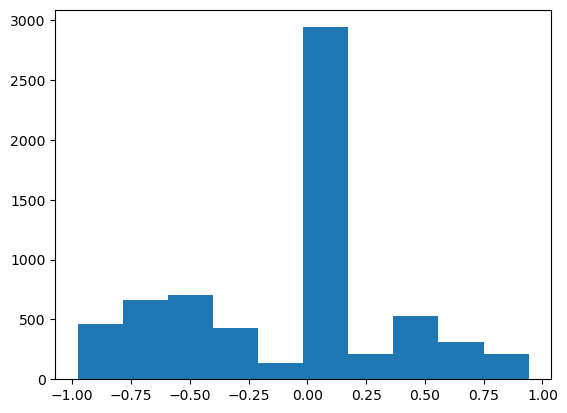

In [15]:
plt.hist(call_comps['compound'])
plt.show()

In [75]:
#ten most positive complaints
pos_10 = call_comps.sort_values(by='compound', ascending=False).head(10)
#ten most negative complaints
neg_10 = call_comps.sort_values(by='compound', ascending=False).tail(10)

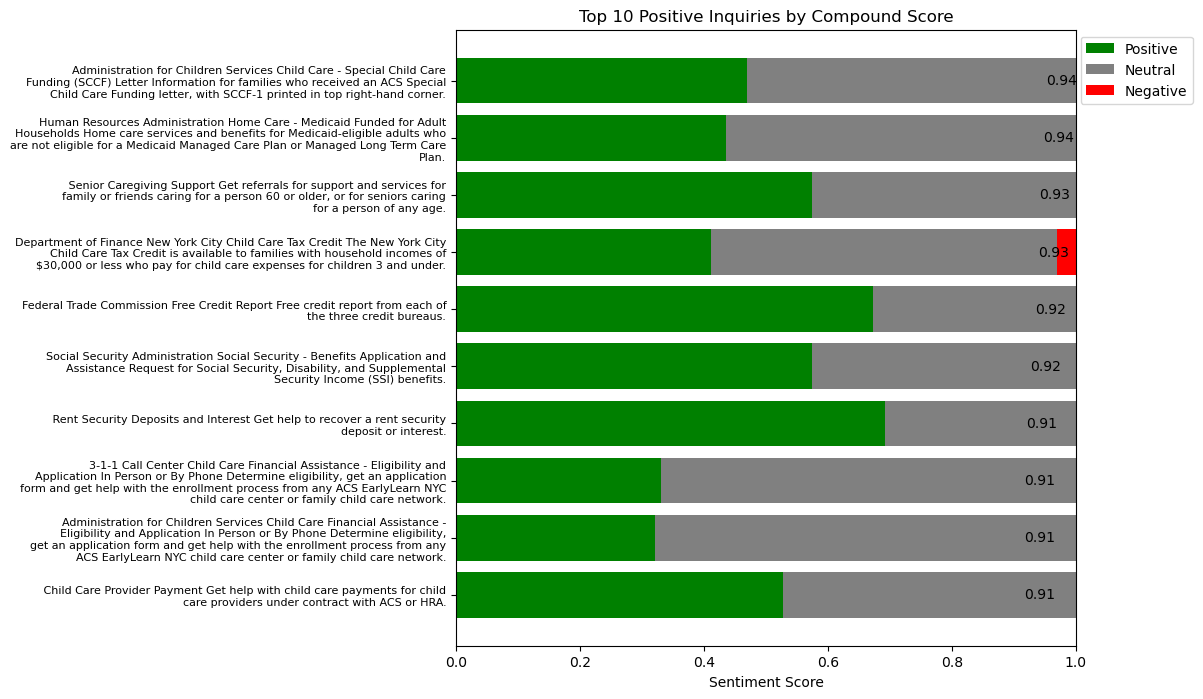

In [64]:
import textwrap

neg_scores = pos_10['neg'][::-1]
neu_scores = pos_10['neu'][::-1]
pos_scores = pos_10['pos'][::-1]
comps_scores = pos_10['compound'][::-1]

fig, ax = plt.subplots(figsize = (8,8))
ax.barh(np.arange(10), pos_scores, label='Positive', color='green')
ax.barh(np.arange(10), neu_scores, left=pos_scores, label='Neutral', color='gray')
ax.barh(np.arange(10), neg_scores, left=pos_scores+neu_scores, label='Negative', color='red')
ax.set_xlabel('Sentiment Score')
ax.set_title('Top 10 Positive Inquiries by Compound Score')
ax.set_yticks(np.arange(10))
# Wrap the text of each y-tick label onto multiple lines
wrapped_labels = [textwrap.fill(label, width=75) for label in pos_10['combined_cats'][::-1]]
ax.set_yticklabels(wrapped_labels, fontsize = 8)
# Add label on top of each bar
for i, score in enumerate(comps_scores):
    ax.text(score+0.01, i, f'{score:.2f}', ha='left', va='center')
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.savefig('../Outputs/Top_10_Positive_Compound_barh.png', bbox_inches='tight')
plt.show()

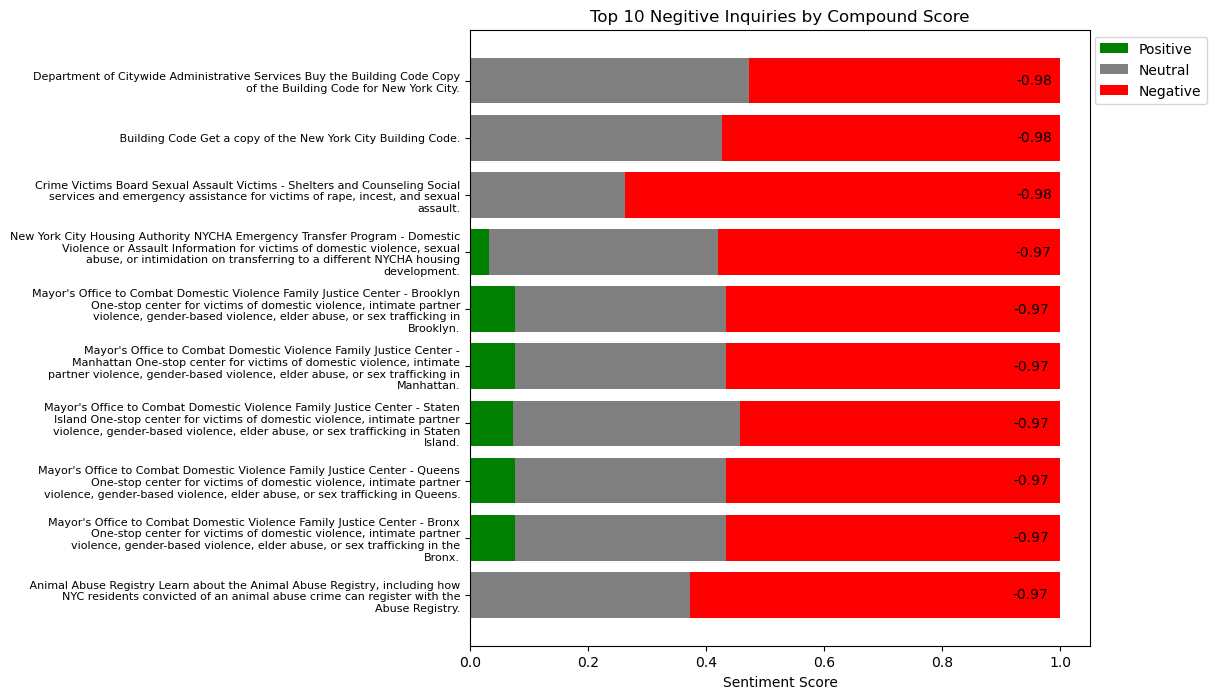

In [74]:
neg_scores = neg_10['neg']
neu_scores = neg_10['neu']
pos_scores = neg_10['pos']
comps_scores = neg_10['compound']

fig, ax = plt.subplots(figsize = (8,8))
ax.barh(np.arange(10), pos_scores, label='Positive', color='green')
ax.barh(np.arange(10), neu_scores, left=pos_scores, label='Neutral', color='gray')
ax.barh(np.arange(10), neg_scores, left=pos_scores+neu_scores, label='Negative', color='red')
ax.set_xlabel('Sentiment Score')
ax.set_title('Top 10 Negitive Inquiries by Compound Score')
ax.set_yticks(np.arange(10))
# Wrap the text of each y-tick label onto multiple lines
wrapped_labels = [textwrap.fill(label, width=75) for label in neg_10['combined_cats']]
ax.set_yticklabels(wrapped_labels, fontsize = 8)
# Add label on top of each bar
for i, score in enumerate(comps_scores):
    ax.text(abs(score)+0.01, i, f'{score:.2f}', ha='right', va='center')
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.savefig('../Outputs/Top_10_Negative_Compound_barh.png', bbox_inches='tight')
plt.show()

In [76]:
#look into neutrals
len(call_comps[call_comps['compound'] == 0])

2753

In [77]:
len(call_comps[call_comps['compound'] != 0])

3843

In [85]:
neu = call_comps[call_comps['compound'] == 0]
neu['cat'].value_counts()

Department of Health and Mental Hygiene                      206
Department of Consumer Affairs                               160
Department of Transportation                                 136
Department of Buildings                                      131
Department of Finance                                        112
                                                            ... 
New York City Police Pension Fund                              1
Federal Aviation Administration                                1
NYS Office of Parks, Recreation and Historic Preservation      1
Borough President of Manhattan                                 1
U.S. Department of Agriculture                                 1
Name: cat, Length: 140, dtype: int64

In [82]:
neu.head(15)

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound
1,76516,3-1-1 Call Center,Service Request Status - General,Status of most Service Requests filed with 311.,3-1-1 Call Center Service Request Status - Gen...,3-1-1 call center service request status - gen...,call center service request status general sta...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0
8,52887,NaN,Service Request Status,Check the status of a Service Request filed wi...,Service Request Status Check the status of a ...,service request status check the status of a ...,service request status check status service re...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0
15,46408,NaN,Birth Certificate Order,Get a copy of a birth certificate.,Birth Certificate Order Get a copy of a birth...,birth certificate order get a copy of a birth...,birth certificate order get copy birth certifi...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0
21,36264,3-1-1 Call Center,Division Transfer,Hidden service for activity coding.,3-1-1 Call Center Division Transfer Hidden ser...,3-1-1 call center division transfer hidden ser...,call center division transfer hidden service a...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0
24,33733,NaN,CFC and Freon Removal,Schedule an appointment for curbside disposal ...,CFC and Freon Removal Schedule an appointment...,cfc and freon removal schedule an appointment...,cfc freon removal schedule appointment curbsid...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0
28,29399,New York City Police Department,Find a Police Precinct or PSA by Location,Find a precinct or police service area (PSA) f...,New York City Police Department Find a Police ...,new york city police department find a police ...,new york city police department find police pr...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0
29,28889,NaN,City Agency or Worker Feedback,Give feedback on the service provided by City ...,City Agency or Worker Feedback Give feedback ...,city agency or worker feedback give feedback ...,city agency worker feedback give feedback serv...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0
30,28866,NaN,Property Tax Bill,Learn about property tax bills and get copies ...,Property Tax Bill Learn about property tax bi...,property tax bill learn about property tax bi...,property building tax bill learn property buil...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0
33,27196,Department of Health and Mental Hygiene,Birth Certificate from 1910 to Present,Request for a certified copy of a New York Cit...,Department of Health and Mental Hygiene Birth ...,department of health and mental hygiene birth ...,department health mental hygiene birth certifi...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0
37,23773,NaN,Property Tax Bill Assistance,Get help with a property tax bill problem.,Property Tax Bill Assistance Get help with a ...,property tax bill assistance get help with a ...,property building tax bill assistance get help...,"{'neg': 0.175, 'neu': 0.649, 'pos': 0.175, 'co...",0.175,0.649,0.175,0.0


In [84]:
len(neu[neu['neu'] != 1])

14